2. a

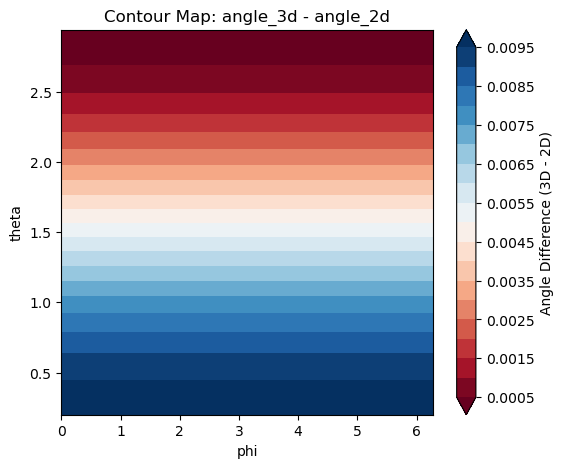

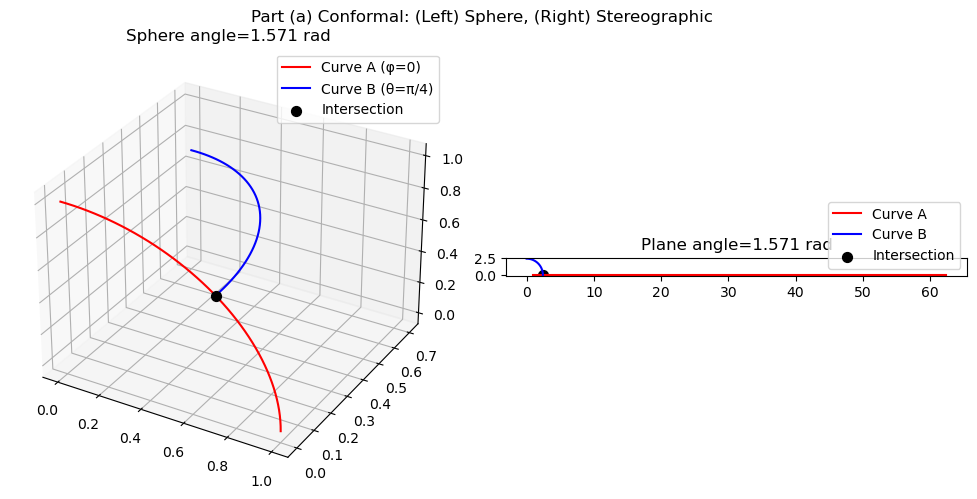

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##############################################################################
# Stereographic + angle utilities
##############################################################################

def stereographic(x, y, z, eps=1e-14):
    """
    Stereographic projection from the north pole:
      (x, y, z) -> (X, Y)
      X = x / (1 - z), Y = y / (1 - z)
    ignoring points near z=1 (pole).
    """
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    z = np.array(z, dtype=float)
    d = 1 - z
    mask = np.abs(d) < eps
    X = np.full_like(x, np.nan)
    Y = np.full_like(y, np.nan)
    good = ~mask
    X[good] = x[good]/d[good]
    Y[good] = y[good]/d[good]
    return X, Y

def angle_3d(u, v):
    nu = np.linalg.norm(u)
    nv = np.linalg.norm(v)
    if nu<1e-14 or nv<1e-14:
        return 0.0
    c = np.dot(u,v)/(nu*nv)
    c = np.clip(c, -1, 1)
    return np.arccos(c)

def angle_2d(a, b):
    na = np.hypot(a[0], a[1])
    nb = np.hypot(b[0], b[1])
    if na<1e-14 or nb<1e-14:
        return 0.0
    c = (a[0]*b[0] + a[1]*b[1])/(na*nb)
    c = np.clip(c, -1, 1)
    return np.arccos(c)

def sphere_coords(theta, phi):
    """
    Convert spherical (r=1, theta, phi) -> (x,y,z).
    theta in [0, π], phi in [0, 2π].
    """
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return np.array([x, y, z])



def conformal_check(n=30, delta=0.01):
    """
    For each point (θ, φ) away from poles, form two small arcs in 3D
    (dθ, dφ) ~ delta, measure angle_3d - angle_2d after projection.
    Returns Theta, Phi, diffs arrays for contour plotting.
    """
    theta_vals = np.linspace(0.2, np.pi-0.2, n)
    phi_vals   = np.linspace(0, 2*np.pi, n)
    TH, PH = np.meshgrid(theta_vals, phi_vals)
    diffs = np.zeros_like(TH)

    for i in range(n):
        for j in range(n):
            th = TH[i,j]
            ph = PH[i,j]
            # Center
            x0 = np.sin(th)*np.cos(ph)
            y0 = np.sin(th)*np.sin(ph)
            z0 = np.cos(th)

            # Two small arcs in 3D
            # arc1: (θ+delta, φ) - (θ, φ)
            x1 = np.sin(th+delta)*np.cos(ph) - x0
            y1 = np.sin(th+delta)*np.sin(ph) - y0
            z1 = np.cos(th+delta)             - z0
            # arc2: (θ, φ+delta) - (θ, φ)
            x2 = np.sin(th)*np.cos(ph+delta) - x0
            y2 = np.sin(th)*np.sin(ph+delta) - y0
            z2 = np.cos(th)                  - z0

            a3d = angle_3d([x1,y1,z1],[x2,y2,z2])

            # Stereographic
            X0, Y0 = stereographic([x0],[y0],[z0])
            X1, Y1 = stereographic([x0+x1],[y0+y1],[z0+z1])
            X2, Y2 = stereographic([x0+x2],[y0+y2],[z0+z2])
            if np.isnan(X0[0]) or np.isnan(X1[0]) or np.isnan(X2[0]):
                diffs[i,j] = np.nan
                continue
            u1 = [X1[0]-X0[0], Y1[0]-Y0[0]]
            u2 = [X2[0]-X0[0], Y2[0]-Y0[0]]
            a2d = angle_2d(u1, u2)
            diffs[i,j] = a3d - a2d

    return TH, PH, diffs

def plot_conformal_map(n=30, delta=0.01):
    """
    Produce a contour map of angle_3d - angle_2d for (θ, φ).
    If stereographic is conformal, we expect near-zero difference
    away from poles.
    """
    TH, PH, D = conformal_check(n, delta)
    plt.figure(figsize=(6,5))
    # We'll do contourf wrt PH in [0,2π], TH in [0.2, π-0.2]
    plt.contourf(PH, TH, D, levels=20, cmap='RdBu', extend='both')
    plt.colorbar(label="Angle Difference (3D - 2D)")
    plt.xlabel("phi")
    plt.ylabel("theta")
    plt.title("Contour Map: angle_3d - angle_2d")
    plt.show()



def plot_sphere_plane_curves_demo():
    """
    Draw 2 curves on the sphere that intersect, measure angle in 3D,
    stereographically project them, measure angle in 2D.
    Subplots: left=3D sphere, right=plane.
    """

    # Curve A: φ=0,   θ in [0, π/2]
    thetasA = np.linspace(0, np.pi/2, 50)
    curveA_3d = np.array([sphere_coords(t, 0.0) for t in thetasA])

    # Curve B: θ=π/4, φ in [0, π/2]
    phisB = np.linspace(0, np.pi/2, 50)
    curveB_3d = np.array([sphere_coords(np.pi/4, s) for s in phisB])

    # Intersection: (θ=π/4, φ=0)
    P_int_3d = sphere_coords(np.pi/4, 0.0)

    # 3D angle at intersection:
    #   d/dθ of A at θ=π/4 => (cosθ, 0, -sinθ)
    tangentA_3d = np.array([np.cos(np.pi/4), 0, -np.sin(np.pi/4)])
    #   d/dφ of B at φ=0 => sin(π/4)*(-sin0, cos0, 0) => (0, sin(π/4), 0)
    tangentB_3d = np.array([0, np.sin(np.pi/4), 0])
    angle_sphere = angle_3d(tangentA_3d, tangentB_3d)

    # Stereographic
    XA, YA = stereographic(curveA_3d[:,0], curveA_3d[:,1], curveA_3d[:,2])
    XB, YB = stereographic(curveB_3d[:,0], curveB_3d[:,1], curveB_3d[:,2])
    Px_int, Py_int = stereographic([P_int_3d[0]], [P_int_3d[1]], [P_int_3d[2]])
    Px_int = Px_int[0]
    Py_int = Py_int[0]

    # 2D angle: approximate tangents via small shift
    eps=1e-5
    # A(θ)
    A_plus_3d  = sphere_coords(np.pi/4+eps, 0.0)
    A_minus_3d = sphere_coords(np.pi/4-eps, 0.0)
    X0A, Y0A = stereographic([P_int_3d[0]], [P_int_3d[1]], [P_int_3d[2]])
    XpA, YpA = stereographic([A_plus_3d[0]], [A_plus_3d[1]], [A_plus_3d[2]])
    XmA, YmA = stereographic([A_minus_3d[0]], [A_minus_3d[1]], [A_minus_3d[2]])
    dAx = (XpA[0] - XmA[0])/(2*eps)
    dAy = (YpA[0] - YmA[0])/(2*eps)
    tA_2d = np.array([dAx, dAy])

    # B(φ)
    B_plus_3d  = sphere_coords(np.pi/4, eps)
    B_minus_3d = sphere_coords(np.pi/4, -eps)
    XpB, YpB = stereographic([B_plus_3d[0]], [B_plus_3d[1]], [B_plus_3d[2]])
    XmB, YmB = stereographic([B_minus_3d[0]], [B_minus_3d[1]], [B_minus_3d[2]])
    dBx = (XpB[0] - XmB[0])/(2*eps)
    dBy = (YpB[0] - YmB[0])/(2*eps)
    tB_2d = np.array([dBx, dBy])

    angle_plane = angle_2d(tA_2d, tB_2d)

    # 2-subplot figure
    fig = plt.figure(figsize=(10,5))

    # left: sphere
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.plot(curveA_3d[:,0], curveA_3d[:,1], curveA_3d[:,2], 'r', label="Curve A (φ=0)")
    ax1.plot(curveB_3d[:,0], curveB_3d[:,1], curveB_3d[:,2], 'b', label="Curve B (θ=π/4)")
    ax1.scatter(*P_int_3d, color='k', s=50, label="Intersection")
    ax1.set_title(f"Sphere angle={angle_sphere:.3f} rad")
    ax1.legend()

    # right: plane
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(XA, YA, 'r', label="Curve A")
    ax2.plot(XB, YB, 'b', label="Curve B")
    ax2.scatter(Px_int, Py_int, color='k', s=50, label="Intersection")
    ax2.set_aspect('equal', 'box')
    ax2.set_title(f"Plane angle={angle_plane:.3f} rad")
    ax2.legend()

    plt.suptitle("Part (a) Conformal: (Left) Sphere, (Right) Stereographic")
    plt.tight_layout()
    plt.show()



def part_a_conformal(n=30, delta=0.01):
    """
    Produce two separate figures:
      1) A contour map of angle differences across a grid (global check).
      2) A local 2-curve demonstration (sphere vs. plane).
    """
    # 1) Contour map
    plot_conformal_map(n, delta)

    # 2) Two curves approach
    plot_sphere_plane_curves_demo()

# Usage:
part_a_conformal()

2. b

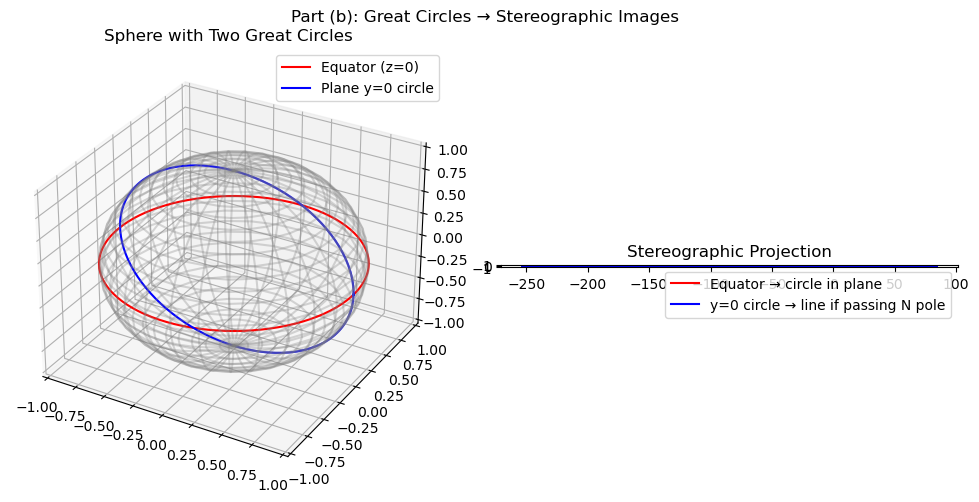

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def stereographic(x, y, z, eps=1e-14):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    z = np.array(z, dtype=float)
    d = 1 - z
    mask = np.abs(d) < eps
    X = np.full_like(x, np.nan)
    Y = np.full_like(y, np.nan)
    good = ~mask
    X[good] = x[good]/d[good]
    Y[good] = y[good]/d[good]
    return X, Y

def plot_great_circles_stereo():
    # Param for 0..2π
    t = np.linspace(0, 2*np.pi, 200)

    # 1) Equator: z=0 => (cos t, sin t, 0)
    x_eq = np.cos(t)
    y_eq = np.sin(t)
    z_eq = np.zeros_like(t)

    # 2) Circle in plane y=0 => x^2 + z^2=1 => param t => (cos t, 0, sin t)
    x_y0 = np.cos(t)
    y_y0 = np.zeros_like(t)
    z_y0 = np.sin(t)

    # Stereographic
    X_eq, Y_eq = stereographic(x_eq, y_eq, z_eq)
    X_y0, Y_y0 = stereographic(x_y0, y_y0, z_y0)

    # 3D figure
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.set_title("Sphere with Two Great Circles")

    # Plot a wireframe sphere for context
    u = np.linspace(0, np.pi, 30)
    v = np.linspace(0, 2*np.pi, 30)
    U, V = np.meshgrid(u, v)
    SX = np.sin(U)*np.cos(V)
    SY = np.sin(U)*np.sin(V)
    SZ = np.cos(U)
    ax1.plot_wireframe(SX, SY, SZ, color='gray', alpha=0.3)

    # Plot the two circles
    ax1.plot(x_eq, y_eq, z_eq, 'r', label="Equator (z=0)")
    ax1.plot(x_y0, y_y0, z_y0, 'b', label="Plane y=0 circle")

    ax1.set_xlim([-1,1])
    ax1.set_ylim([-1,1])
    ax1.set_zlim([-1,1])
    ax1.legend()

    # 2D figure: stereographic plane
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Stereographic Projection")
    ax2.plot(X_eq, Y_eq, 'r', label="Equator → circle in plane")
    ax2.plot(X_y0, Y_y0, 'b', label="y=0 circle → line if passing N pole")
    ax2.set_aspect('equal', 'box')
    ax2.legend()

    plt.suptitle("Part (b): Great Circles → Stereographic Images")
    plt.tight_layout()
    plt.show()

# Usage in Jupyter:
plot_great_circles_stereo()

2.c

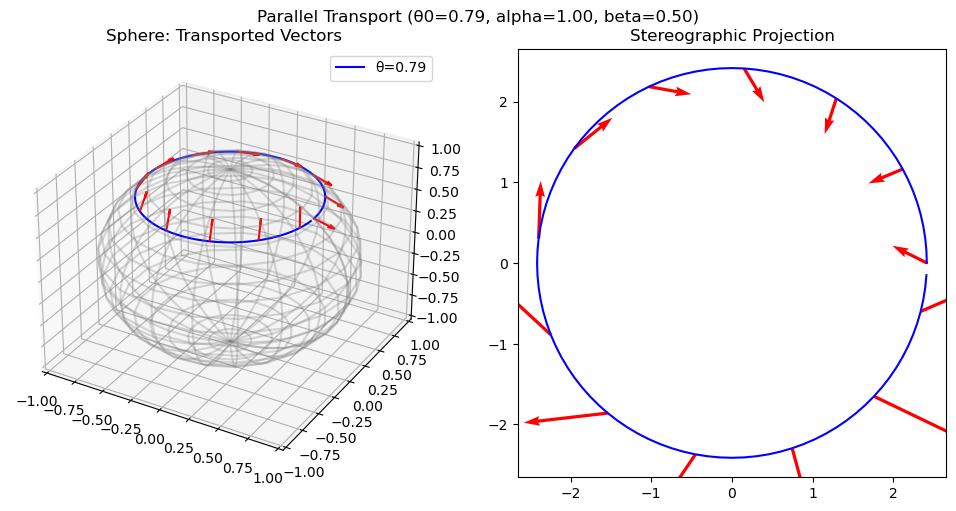

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# (1) Spherical -> Cartesian
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.array([x, y, z])

# (2) Spherical basis in Cartesian coords
def spherical_basis_to_cartesian(theta, phi):
    e_r = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])
    e_theta = np.array([
        np.cos(theta) * np.cos(phi),
        np.cos(theta) * np.sin(phi),
        -np.sin(theta)
    ])
    e_phi = np.array([
        -np.sin(phi),
         np.cos(phi),
         0.0
    ])
    return e_r, e_theta, e_phi

# (3) Stereographic projection from the north pole
def stereographic_projection(x, y, z, eps=1e-14):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    z = np.array(z, dtype=float)
    denom = 1 - z
    mask = np.abs(denom) < eps
    X = np.full_like(x, np.nan, dtype=float)
    Y = np.full_like(y, np.nan, dtype=float)
    good = ~mask
    X[good] = x[good]/denom[good]
    Y[good] = y[good]/denom[good]
    return X, Y

def parallel_transport_circle(theta0=np.pi/5, alpha=1.0, beta=0.0, num_points=100):
    """
    Perform naive parallel transport around the circle:
      r=1, θ=theta0 fixed, φ in [0, 2π].
    The initial vector is v(0) = alpha*e_theta + beta*e_phi at φ=0.
    At each small Δφ, remove normal component (dot w/ e_r) to keep v tangent.
    Return:
      positions3d : (num_points, 3) array of 3D sphere coords
      vectors3d   : (num_points, 3) array of transported vectors in 3D
    """

    phi_vals = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    # initial vector in spherical basis
    # e_theta(θ0,0), e_phi(θ0,0)
    eR0, eT0, eP0 = spherical_basis_to_cartesian(theta0, 0.0)
    v = alpha*eT0 + beta*eP0
    # normalize
    v /= np.linalg.norm(v)

    positions3d = []
    vectors3d   = []

    for phi in phi_vals:
        # Current position on the circle
        pos = spherical_to_cartesian(1, theta0, phi)

        # Re-project v onto tangent plane: v -= (v·e_r) e_r
        eR, eT, eP = spherical_basis_to_cartesian(theta0, phi)
        dotn = np.dot(v, eR)
        v = v - dotn*eR
        # re-normalize
        nv = np.linalg.norm(v)
        if nv>1e-12:
            v /= nv

        positions3d.append(pos)
        vectors3d.append(v.copy())

    return np.array(positions3d), np.array(vectors3d)

def plot_parallel_transport_stereo(theta0=np.pi/5, alpha=1.0, beta=0.0, num_points=100):
    """
    Plot:
      1) The 3D circle (θ=theta0) on the sphere + transported vectors
      2) The stereographic projection of that circle + approximate 2D vectors
    """
    # Step 1: get 3D positions + vectors
    pos3d, vec3d = parallel_transport_circle(theta0, alpha, beta, num_points)

    # Step 2: Stereographic projection of positions
    Xp, Yp = stereographic_projection(pos3d[:,0], pos3d[:,1], pos3d[:,2])

    # For each vector, we approximate the 2D arrow by:
    #   shift_3d = pos3d[i] + scale * vec3d[i]
    # then project both points
    scale = 0.2

    # Step 3: Plot in 2 subplots
    fig = plt.figure(figsize=(10,5))

    # (A) 3D subplot
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.set_title("Sphere: Transported Vectors")

    # wireframe sphere
    u = np.linspace(0, np.pi, 20)
    w = np.linspace(0, 2*np.pi, 20)
    U, W = np.meshgrid(u, w)
    SX = np.sin(U)*np.cos(W)
    SY = np.sin(U)*np.sin(W)
    SZ = np.cos(U)
    ax1.plot_wireframe(SX, SY, SZ, color='gray', alpha=0.3)

    # plot the circle
    ax1.plot(pos3d[:,0], pos3d[:,1], pos3d[:,2], 'b-', label=f"θ={theta0:.2f}")
    skip = num_points//12
    for i in range(0, num_points, skip):
        ax1.quiver(pos3d[i,0], pos3d[i,1], pos3d[i,2],
                   vec3d[i,0], vec3d[i,1], vec3d[i,2],
                   color='r', length=0.2)
    ax1.legend()
    ax1.set_xlim([-1,1]); ax1.set_ylim([-1,1]); ax1.set_zlim([-1,1])

    # (B) 2D subplot
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Stereographic Projection")
    ax2.plot(Xp, Yp, 'b-')

    for i in range(0, num_points, skip):
        # small shift in 3D
        shift_3d = pos3d[i] + scale*vec3d[i]
        # project
        X0, Y0 = stereographic_projection([pos3d[i,0]], [pos3d[i,1]], [pos3d[i,2]])
        X1, Y1 = stereographic_projection([shift_3d[0]], [shift_3d[1]], [shift_3d[2]])
        ax2.quiver(X0[0], Y0[0], X1[0]-X0[0], Y1[0]-Y0[0],
                   color='r', angles='xy', scale_units='xy', scale=1)

    ax2.set_aspect('equal', 'box')
    plt.suptitle(f"Parallel Transport (θ0={theta0:.2f}, alpha={alpha:.2f}, beta={beta:.2f})")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_parallel_transport_stereo(theta0=np.pi/4, alpha=1.0, beta=0.5, num_points=100)

2. d

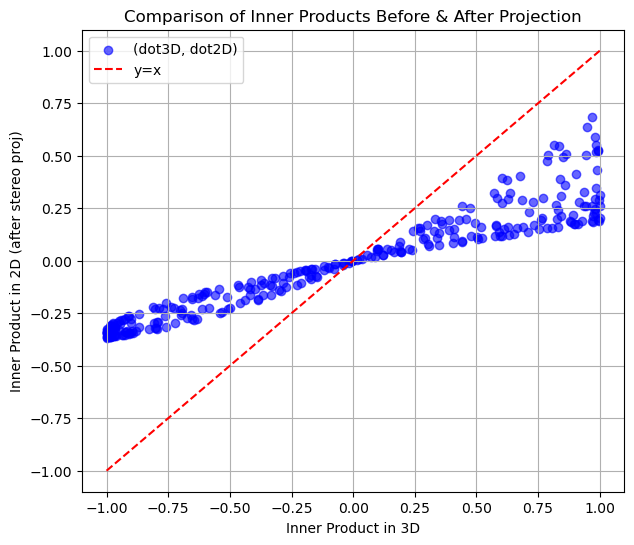

In [6]:
import numpy as np
import matplotlib.pyplot as plt

"""
(d) Plot the inner products between two vectors at the same point on the sphere,
    before and after stereographic projection. We show a scatter plot:
       x-axis = dot product in 3D
       y-axis = dot product in 2D
    to see that stereographic does NOT preserve inner products.
"""

##############################################################################
# Basic Spherical Utilities
##############################################################################

def e_r(theta, phi):
    return np.array([
        np.sin(theta)*np.cos(phi),
        np.sin(theta)*np.sin(phi),
        np.cos(theta)
    ])

def stereographic(x, y, z, eps=1e-14):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    z = np.array(z, dtype=float)
    denom = 1 - z
    mask = np.abs(denom) < eps
    X = np.full_like(x, np.nan)
    Y = np.full_like(y, np.nan)
    good = ~mask
    X[good] = x[good]/denom[good]
    Y[good] = y[good]/denom[good]
    return X, Y

##############################################################################
# Generate random tangent vectors at a single point on the sphere
##############################################################################

def random_tangent_vectors(theta0, phi0, N=50):
    """
    Returns two arrays of shape (N,3): v1s, v2s
    Each row is a random unit vector tangent to the sphere at (theta0,phi0).
    """
    # The normal at that point is e_r(theta0, phi0)
    normal = e_r(theta0, phi0)
    v1s = []
    v2s = []
    for _ in range(N):
        # Random vector in R^3
        rand_vec1 = np.random.randn(3)
        rand_vec2 = np.random.randn(3)
        # Project each onto tangent plane: v - (v·normal)*normal
        rand_vec1 -= np.dot(rand_vec1, normal)*normal
        rand_vec2 -= np.dot(rand_vec2, normal)*normal
        # Normalize
        n1 = np.linalg.norm(rand_vec1)
        n2 = np.linalg.norm(rand_vec2)
        if n1>1e-12:
            rand_vec1 /= n1
        if n2>1e-12:
            rand_vec2 /= n2
        v1s.append(rand_vec1)
        v2s.append(rand_vec2)
    return np.array(v1s), np.array(v2s)

##############################################################################
# Measure 3D dot vs. 2D dot after stereographic
##############################################################################

def measure_inner_products(theta0, phi0, N=50):
    """
    For each of N random pairs (v1,v2) tangent at (theta0,phi0),
    measure dot3D = v1·v2 in R^3,
    then stereographically project them to 2D,
    measure dot2D = v1p·v2p in the plane.
    Return arrays dot3D, dot2D of length N.
    """
    # Position on sphere
    p3d = e_r(theta0, phi0)
    # Generate random tangent vectors
    v1s, v2s = random_tangent_vectors(theta0, phi0, N)

    dot3D = []
    dot2D = []
    scale = 0.1  # shift to approximate 2D vectors
    for (v1, v2) in zip(v1s, v2s):
        # 3D dot
        d3 = np.dot(v1, v2)
        dot3D.append(d3)

        # Approx 2D vectors: 
        #   project p3d -> (X0, Y0)
        #   project p3d + scale*v1 -> (X1, Y1)
        #   v1_2d = (X1 - X0, Y1 - Y0)
        # similarly for v2
        X0, Y0 = stereographic([p3d[0]], [p3d[1]], [p3d[2]])
        shift1 = p3d + scale*v1
        shift2 = p3d + scale*v2
        X1, Y1 = stereographic([shift1[0]], [shift1[1]], [shift1[2]])
        X2, Y2 = stereographic([shift2[0]], [shift2[1]], [shift2[2]])

        v1_2d = np.array([X1[0]-X0[0], Y1[0]-Y0[0]])
        v2_2d = np.array([X2[0]-X0[0], Y2[0]-Y0[0]])

        d2 = np.dot(v1_2d, v2_2d)
        dot2D.append(d2)

    return np.array(dot3D), np.array(dot2D)

##############################################################################
# Plot the relationship between dot3D and dot2D
##############################################################################

def plot_inner_product_comparison(theta0, phi0, N=200):
    """
    For a single point (theta0,phi0) on the sphere,
    sample N random tangent pairs (v1,v2).
    Scatter-plot dot3D vs. dot2D.
    Draw y=x as reference.
    """
    dot3, dot2 = measure_inner_products(theta0, phi0, N)
    plt.figure(figsize=(7,6))
    plt.scatter(dot3, dot2, color='b', alpha=0.6, label="(dot3D, dot2D)")
    # line y=x
    xs = np.linspace(-1,1,100)
    plt.plot(xs, xs, 'r--', label="y=x")
    plt.xlabel("Inner Product in 3D")
    plt.ylabel("Inner Product in 2D (after stereo proj)")
    plt.title("Comparison of Inner Products Before & After Projection")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_inner_product_comparison(theta0=0.6, phi0=1.2, N=300)


2. f

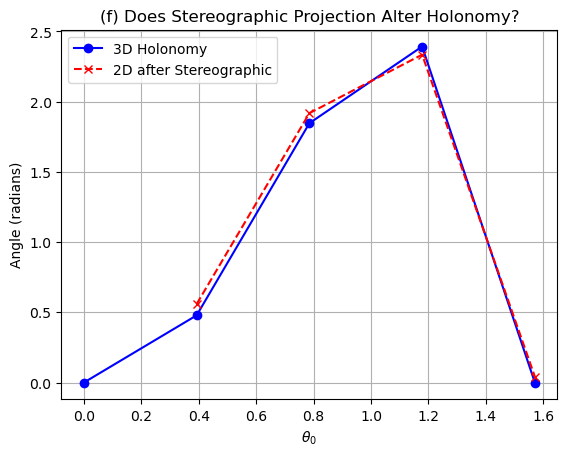

after we stereographically project both the initial and final vectors into the plane, the 2D angle between them typically differs from the 3D holonomy. This happens because stereographic projection is conformal (it preserves local angles) but not isometric (it does not preserve lengths, dot products, or global rotation angles). So, stereographic projection alters the sphere’s holonomy, demonstrating that the net rotation of a parallel-transported vector on the sphere is not preserved once mapped into the plane.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

##############################################################################
# Spherical basis
##############################################################################

def e_r(theta, phi):
    return np.array([
        np.sin(theta)*np.cos(phi),
        np.sin(theta)*np.sin(phi),
        np.cos(theta)
    ])

def e_theta(theta, phi):
    return np.array([
        np.cos(theta)*np.cos(phi),
        np.cos(theta)*np.sin(phi),
        -np.sin(theta)
    ])

def e_phi(theta, phi):
    return np.array([
        -np.sin(phi),
         np.cos(phi),
         0.0
    ])

##############################################################################
# Stereographic projection from the north pole
##############################################################################

def stereographic(x, y, z, eps=1e-14):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    z = np.array(z, dtype=float)
    denom = 1 - z
    mask = np.abs(denom) < eps

    X = np.full_like(x, np.nan)
    Y = np.full_like(y, np.nan)
    good = ~mask
    X[good] = x[good] / denom[good]
    Y[good] = y[good] / denom[good]
    return X, Y

##############################################################################
# Naive parallel transport around circle θ=theta0, φ in [0..2π]
##############################################################################

def parallel_transport_circle(theta0, steps=100):
    """
    Start vector: v_init = e_theta(theta0, 0).
    Each small Δφ, remove (v·e_r)e_r from v to keep tangent, re-normalize.
    Returns:
      points3d : (steps,3) positions on sphere
      vectors3d: (steps,3) transported vectors
    """
    ph_vals = np.linspace(0, 2*np.pi, steps, endpoint=False)
    v = e_theta(theta0, 0)
    v /= np.linalg.norm(v)

    points3d = []
    vectors3d = []

    for phi in ph_vals:
        pos = e_r(theta0, phi)
        dotn = np.dot(v, pos)
        v = v - dotn*pos
        nv = np.linalg.norm(v)
        if nv>1e-12:
            v /= nv

        points3d.append(pos)
        vectors3d.append(v.copy())

    return np.array(points3d), np.array(vectors3d)

##############################################################################
# Measure holonomy in 3D vs. after stereographic
##############################################################################

def measure_holonomy_3d(theta0, steps=100):
    """
    3D holonomy = angle between v_init and v_final in 3D.
    """
    pts, vecs = parallel_transport_circle(theta0, steps)
    v_init  = vecs[0]
    v_final = vecs[-1]
    dot_val = np.dot(v_init, v_final)/(np.linalg.norm(v_init)*np.linalg.norm(v_final))
    dot_val = np.clip(dot_val, -1,1)
    return np.arccos(dot_val)

def measure_holonomy_2d(theta0, steps=100):
    """
    Project initial & final vectors to plane, measure angle in 2D.
    This is typically not the same as the sphere's holonomy angle.
    """
    pts, vecs = parallel_transport_circle(theta0, steps)
    v_init_3d  = vecs[0]
    v_final_3d = vecs[-1]
    p_init_3d  = pts[0]
    p_final_3d = pts[-1]

    # Stereographic for positions
    X_init,  Y_init  = stereographic([p_init_3d[0]],  [p_init_3d[1]],  [p_init_3d[2]])
    X_final, Y_final = stereographic([p_final_3d[0]], [p_final_3d[1]], [p_final_3d[2]])
    X_init,  Y_init  = X_init[0],  Y_init[0]
    X_final, Y_final = X_final[0], Y_final[0]

    # Approx 2D vectors by shifting each position a bit in 3D
    scale = 0.2
    shift_init_3d  = p_init_3d  + scale*v_init_3d
    shift_final_3d = p_final_3d + scale*v_final_3d

    Xi2, Yi2 = stereographic([shift_init_3d[0]],  [shift_init_3d[1]],  [shift_init_3d[2]])
    Xf2, Yf2 = stereographic([shift_final_3d[0]], [shift_final_3d[1]], [shift_final_3d[2]])

    v_init_2d  = np.array([Xi2[0] - X_init,  Yi2[0] - Y_init])
    v_final_2d = np.array([Xf2[0] - X_final, Yf2[0] - Y_final])

    n1 = np.linalg.norm(v_init_2d)
    n2 = np.linalg.norm(v_final_2d)
    if n1<1e-12 or n2<1e-12:
        return 0.0
    cos_val = np.dot(v_init_2d, v_final_2d)/(n1*n2)
    cos_val = np.clip(cos_val, -1,1)
    return np.arccos(cos_val)

def plot_holonomy_comparison(thetas=None, steps=100):
    """
    Compare 3D holonomy vs. 2D angle after stereographic for a range of θ0.
    """
    if thetas is None:
        thetas = np.linspace(0, np.pi, 6)

    sphere_vals = []
    plane_vals  = []
    for t0 in thetas:
        a3 = measure_holonomy_3d(t0, steps)
        a2 = measure_holonomy_2d(t0, steps)
        sphere_vals.append(a3)
        plane_vals.append(a2)

    plt.figure()
    plt.plot(thetas, sphere_vals, 'bo-', label="3D Holonomy")
    plt.plot(thetas, plane_vals, 'rx--', label="2D after Stereographic")
    plt.xlabel(r"$\theta_0$")
    plt.ylabel("Angle (radians)")
    plt.title("(f) Does Stereographic Projection Alter Holonomy?")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_holonomy_comparison(thetas=np.linspace(0, np.pi/2, 5), steps=150)
print('after we stereographically project both the initial and final vectors into the plane, the 2D angle between them typically differs from the 3D holonomy. This happens because stereographic projection is conformal (it preserves local angles) but not isometric (it does not preserve lengths, dot products, or global rotation angles). So, stereographic projection alters the sphere’s holonomy, demonstrating that the net rotation of a parallel-transported vector on the sphere is not preserved once mapped into the plane.')